In [ ]:
import torchvision as thv
train = thv.datasets.MNIST('./', download=True , train=True)
val = thv.datasets.MNIST('./', download=True , train=False)
print(train.data.shape , len(train.targets))

torch.Size([60000, 28, 28]) 60000


In [ ]:
import torch
from torch import nn, optim
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2

In [ ]:
x_train = np.zeros([10000,28,28])
y_train = np.zeros([10000])

for i in range(10):
  x_train[i*1000:(i+1)*1000,:] = train.data[np.where(train.targets==i)][:1000,:,:].numpy()
  y_train[i*1000:(i+1)*1000] = np.array([i]*1000)

x_train = x_train.reshape(x_train.shape[0],-1)/255

# shuffle data
index = np.arange(x_train.shape[0])
np.random.shuffle(index)
x_train, y_train = x_train[index], y_train[index]

In [ ]:
x_ds = np.empty([10000,196])
for i in range(x_train.shape[0]):
  x_ds[i] = cv2.resize(x_train[i].reshape((28,28)),(14,14)).flatten()

x_ds[x_ds>1/2]=1
x_ds[x_ds<=1/2]=0

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class vae(nn.Module):
  def __init__(self):
    super(vae, self).__init__()
    
    self.linear1 = nn.Linear(196, 128)
    self.linear_mu = nn.Linear(128, 8)
    self.linear_std = nn.Linear(128, 8)
    self.linear2 = nn.Linear(8, 128)
    self.linear3 = nn.Linear(128, 196)
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  def encode(self, x):
    x = self.linear1(x)
    x = self.tanh(x)
    mu = self.linear_mu(x)
    std = self.linear_std(x)
    return mu, std
  
  def decode(self, mu, std): # reparameterize here
    x = mu + torch.randn_like(std)*std
    x = self.linear2(x)
    x = self.tanh(x)
    x = self.linear3(x)
    x = self.sigmoid(x)
    return x

  def forward(self, x):
    mu, std = self.encode(x)
    x = self.decode(mu, std)
    return x, mu, std

model = vae().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def cal_loss(x, x_new, mu, std):
  # bce = nn.BCELoss(x, x_new, reduction='sum')
  bce = nn.functional.binary_cross_entropy(x_new, x, reduction='sum') #order matters!!!
  kld = -(1/2)*torch.sum(1+torch.log(std**2)-mu.pow(2)-std.pow(2))
  return bce, kld, bce+kld

In [ ]:
from torch.utils.data import Dataset, DataLoader

class Mydata(Dataset):
    def __init__(self, X, y):
        self.x = X
        self.y = y

    def __getitem__(self, idx):
        assert idx < len(self.x)
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

dataset = Mydata(x_ds, y_train)
dataloader = DataLoader(dataset, batch_size = 128, shuffle=True)

In [ ]:
epochs = 50

def train():
  model.train()
  bce_list, kld_list = [], []
  for i in range(epochs):
    for data, target in dataloader:
      optimizer.zero_grad()
      data = data.to(torch.float32)
      data = data.to(device)
      data_new, mu, std = model(data)
      bce, kld, loss = cal_loss(data, data_new, mu, std)
      bce_list.append(bce.item()/len(data))
      kld_list.append(kld.item()/len(data))
      loss.backward()
      optimizer.step()
    print(f'Epoch: {i+1}, training loss: {loss.item()}')
  return bce_list, kld_list

bce_list, kld_list = train()

Epoch: 1, training loss: 958.8974609375
Epoch: 2, training loss: 811.8834228515625
Epoch: 3, training loss: 810.1966552734375
Epoch: 4, training loss: 734.247314453125
Epoch: 5, training loss: 744.8869018554688
Epoch: 6, training loss: 737.365234375
Epoch: 7, training loss: 724.6705322265625
Epoch: 8, training loss: 745.3970947265625
Epoch: 9, training loss: 723.2485961914062
Epoch: 10, training loss: 698.76806640625
Epoch: 11, training loss: 628.1073608398438
Epoch: 12, training loss: 652.4734497070312
Epoch: 13, training loss: 643.556640625
Epoch: 14, training loss: 653.5883178710938
Epoch: 15, training loss: 575.675537109375
Epoch: 16, training loss: 562.1830444335938
Epoch: 17, training loss: 634.499267578125
Epoch: 18, training loss: 617.80517578125
Epoch: 19, training loss: 578.3196411132812
Epoch: 20, training loss: 608.6863403320312
Epoch: 21, training loss: 627.6354370117188
Epoch: 22, training loss: 571.32666015625
Epoch: 23, training loss: 581.96435546875
Epoch: 24, training

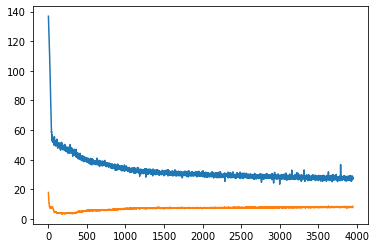

In [ ]:
plt.plot(bce_list)
plt.plot(kld_list)

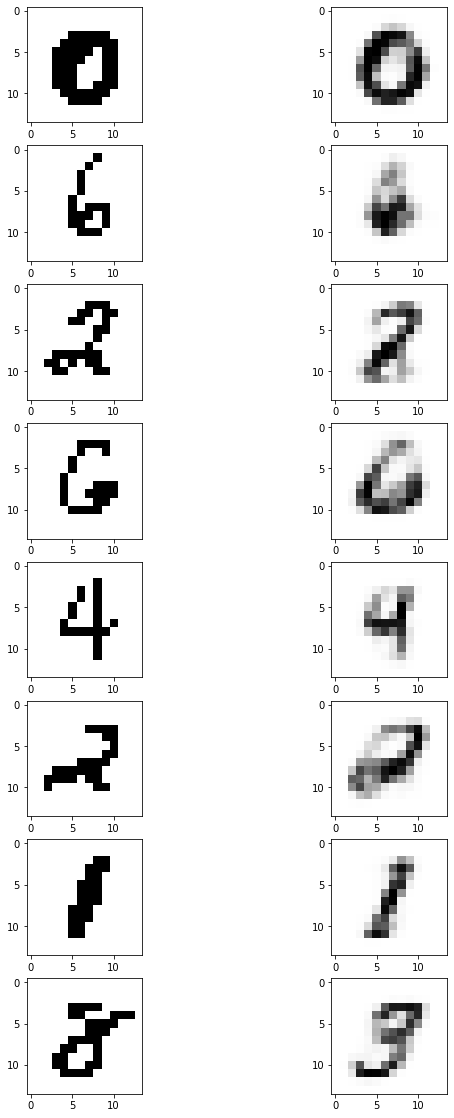

In [ ]:
for data, target in dataloader:
  break

data_new, mu, std = model(data.to(torch.float32))

f, ax = plt.subplots(8, 2, figsize=(10,20))
for i in range(8):
    ax[i,0].imshow(data[i].reshape(14,14), cmap='Greys')
    ax[i,1].imshow(data_new[i].detach().numpy().reshape(14,14), cmap='Greys')

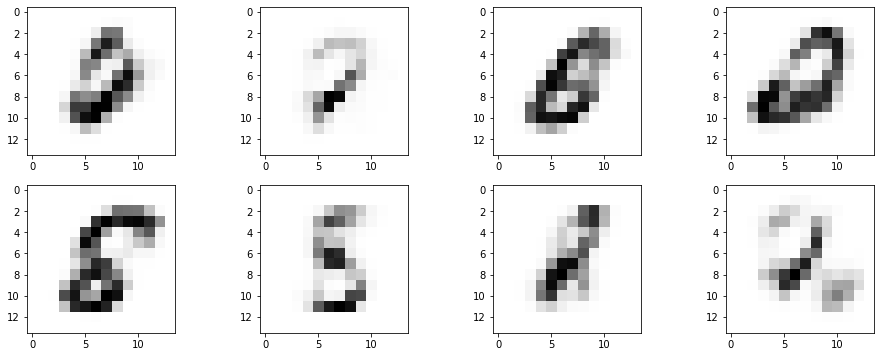

In [ ]:
mu = torch.zeros(8,8)
std = torch.ones(8,8)

with torch.no_grad():
    sample = model.decode(mu, std)

image = sample.view(8, 14, 14)

f, ax = plt.subplots(2, 4, figsize=(16,6))
n = 0
for i in range(2):
    for j in range(4):
        ax[i,j].imshow(image[n], cmap='Greys')
        n += 1

In [ ]:
epochs = 100

model1 = vae().to(device)
optimizer = optim.Adam(model1.parameters(), lr=1e-3)

mu = torch.zeros(100,8)
std = torch.ones(100,8)

def val():
  model1.train()
  update, bce_val_list, bce_train_list = 0, [], []
  for i in range(epochs):
    for data, target in dataloader:
      optimizer.zero_grad()
      data = data.to(torch.float32)
      data = data.to(device)
      data_new, mu, std = model1(data)
      bce, kld, loss = cal_loss(data, data_new, mu, std)
      loss.backward()
      optimizer.step()
      update += 1
      if update%100 ==0:
        val_data = model1.decode(mu, std)
        val_new, mu, std = model1(val_data)
        bce_val, kld_val, loss_val = cal_loss(val_data, val_new, mu, std)
        bce_val_list.append(bce_val.item())
        bce_train_list.append(bce.item())
    print(f'Epoch: {i+1}, training loss: {loss.item()}')
  return bce_val_list, bce_train_list

bce_val_list, bce_train_list = val()

Epoch: 1, training loss: 946.9632568359375
Epoch: 2, training loss: 843.30712890625
Epoch: 3, training loss: 807.582763671875
Epoch: 4, training loss: 788.4015502929688
Epoch: 5, training loss: 824.69189453125
Epoch: 6, training loss: 715.2081298828125
Epoch: 7, training loss: 668.7501831054688
Epoch: 8, training loss: 699.2891235351562
Epoch: 9, training loss: 654.1085205078125
Epoch: 10, training loss: 682.2589721679688
Epoch: 11, training loss: 639.1740112304688
Epoch: 12, training loss: 628.816162109375
Epoch: 13, training loss: 612.9767456054688
Epoch: 14, training loss: 669.60595703125
Epoch: 15, training loss: 660.8699951171875
Epoch: 16, training loss: 591.4276733398438
Epoch: 17, training loss: 588.368408203125
Epoch: 18, training loss: 604.9248046875
Epoch: 19, training loss: 639.554931640625
Epoch: 20, training loss: 573.6407470703125
Epoch: 21, training loss: 567.4954223632812
Epoch: 22, training loss: 546.283447265625
Epoch: 23, training loss: 673.3963012695312
Epoch: 24, 

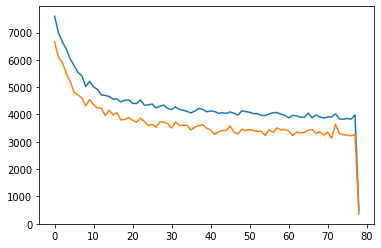

In [ ]:
plt.plot(bce_val_list)
plt.plot(bce_train_list)